In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
import warnings


warnings.filterwarnings("ignore")


**Мы наблюдаем внезапное падение активной аудитории! Нужно разобраться, какие пользователи не смогли зайти в приложение, что их объединяет?**

## Подключение к базе данных

In [2]:
connection = {'host': 'https://karpov_courses_clickhouse_db',
              'database':'simulator_20221220',
              'user':'user_name', 
              'password':'password'
             }

query = '''
select count(distinct user_id) as users,
       toDate(time) as date
from {db}.feed_actions
group by date
'''

df_act = ph.read_clickhouse(query, connection=connection)

## Анализ данных

Нарисуем график количества уникальных пользователей от даты

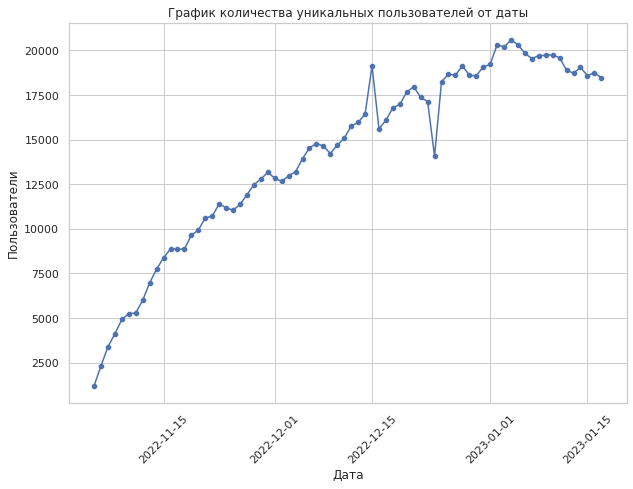

In [3]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={"figure.figsize": (10, 7)}
)

ax = sns.lineplot(data=df_act, x="date", y="users")
ax = sns.scatterplot(data=df_act, x="date", y="users")
ax.set(title="График количества уникальных пользователей от даты")
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='Дата', ylabel='Пользователи')
plt.show()

Найдем дату аномально низкого количества уникальных пользователей

In [4]:
df_act[df_act.date == "2022-12-24"]

,users,date
49,14073,2022-12-24


Получение данных для анализа падения активной аудиории по странам

In [5]:
query = '''
select count(distinct user_id) as users,
       country,
       toDate(time) as date
from {db}.feed_actions
group by date, country
'''

df_country = ph.read_clickhouse(query, connection=connection)

Возьмем -5 и +5 дней от 2022-12-24 и найдем их средние значения тем самым "интерполировав средним" эту дату, правда это можно было селать линейной регрессией с преобразованием данных, но самих данных для такого рода оенки не так велико, поэтому ограничимся средним.

In [6]:
df_country_1 = df_country[df_country.date.isin([
                          "2022-12-19", "2022-12-20",
                          "2022-12-21", "2022-12-22",
                          "2022-12-23", "2022-12-25",
                          "2022-12-26", "2022-12-27",
                          "2022-12-28", "2022-12-29"])
                        ].groupby("country", as_index=False)\
                         .agg({"users": "mean"})\
                         .sort_values(by="country")

In [7]:
df_country_2 = df_country[df_country.date == "2022-12-24"].sort_values(by="country")

In [8]:
print("Интерполированное количество пользователей на 2022-12-24:", 
      round(df_country_1.users.sum()))

df_country_m = df_country_1.merge(df_country_2, on="country", how="inner")
dlt_p = (df_country_2["users"].values - df_country_1["users"].values)\
         / df_country_1["users"].values
df_country_m["delta_percent"] = np.round(100 * dlt_p, 1)
df_country_m.columns = ["country", "users_avg", "users", "date", "delta_percent"]
df_country_m.sort_values(by="delta_percent", 
                         ascending=False)

Интерполированное количество пользователей на 2022-12-24: 18036


,country,users_avg,users,date,delta_percent
2,Cyprus,17.3,20,2022-12-24,15.6
6,Latvia,18.3,19,2022-12-24,3.8
5,Kazakhstan,357.3,362,2022-12-24,1.3
9,Turkey,177.9,180,2022-12-24,1.2
10,Ukraine,897.1,906,2022-12-24,1.0
0,Azerbaijan,169.9,167,2022-12-24,-1.7
1,Belarus,366.2,326,2022-12-24,-11.0
4,Finland,179.4,155,2022-12-24,-13.6
8,Switzerland,19.1,16,2022-12-24,-16.2
7,Russia,15814.2,11908,2022-12-24,-24.7


Выше мы видим много стран которые отличаются по количеству уникальных пользователей, но нас будут интересовать Russia потому что в ней находтся основная часть пользователей и абсолютная разница пользователей там высокая и оказывает большой эффект в отрицательном скачке пользователей.

Получение данных для анализа падения активной аудиории по городам

In [9]:
query = '''
select count(distinct user_id) as users,
       city,
       toDate(time) as date
from {db}.feed_actions
where country = 'Russia'
group by date, city
'''

df_city = ph.read_clickhouse(query, connection=connection)

In [10]:
df_city_1 = df_city[df_city.date.isin([
                              "2022-12-19", "2022-12-20",
                              "2022-12-21", "2022-12-22",
                              "2022-12-23", "2022-12-25",
                              "2022-12-26", "2022-12-27",
                              "2022-12-28", "2022-12-29"])].groupby("city", 
                                                            as_index=False)\
                                                           .agg({"users": "mean"})

In [11]:
df_city_2 = df_city[df_city.date == "2022-12-24"].sort_values(by="city")

In [12]:
df_city_m = df_city_1.merge(df_city_2, 
                            on="city", 
                            how="left").sort_values(by="users_x",
                                                     ascending=False)
df_city_m.columns = ["city", "users_avg", "users", "date"]
res_nans = df_city_m[df_city_m.users.isna()]
print("Количество стран которые присутствували в -5 и +5",
      "от даты 2022-12-24 и отсутствовали 2022-12-24:",
      res_nans.shape[0])
res_nans.head()

Количество стран которые присутствували в -5 и +5 от даты 2022-12-24 и отсутствовали 2022-12-24: 694


,city,users_avg,users,date
1034,Moscow,2424.500000,NaN,NaT
1416,Saint Petersburg,758.800000,NaN,NaT
1167,Novosibirsk,229.600000,NaN,NaT
1979,Yekaterinburg,214.900000,NaN,NaT
1562,Sorochinsk,3.666667,NaN,NaT


Как мы видим выше что основная аудитория присутствует в городах Moscow, Saint Petersburg, Novosibirsk и Yekaterinburg в остальных городах аудитории мало, хотя и городов очень много.

**Вывод:**
<br/>
<br/>
Пользователи из Russia в 694 городах особенно из Moscow, Saint Petersburg, Novosibirsk и Yekaterinburg люди не смогли зайти в приложение 2022-12-24, где наблюдалось внезапное падение активной аудитории.